In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder , StandardScaler
from scipy.stats import chi2_contingency , ttest_ind

In [4]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print('Null values in each column:\n', df.isnull().sum())
print('Dataset summary :\n', df.describe())

df.dropna(inplace=True)

Null values in each column:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Dataset summary :
        SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [6]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['Partner'] = le.fit_transform(df['Partner'])
df['Dependents'] = le.fit_transform(df['Dependents'])
df['PhoneService'] = le.fit_transform(df['PhoneService'])
df['PaperlessBilling'] = le.fit_transform(df['PaperlessBilling'])
df['Churn'] = le.fit_transform(df['Churn'])

In [13]:
for col in ['InternetService', 'Contract', 'PaymentMethod']:
    if col not in df.columns:
        print(f"Column '{col}' not found in DataFrame.")


Column 'InternetService' not found in DataFrame.
Column 'Contract' not found in DataFrame.
Column 'PaymentMethod' not found in DataFrame.


In [16]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())


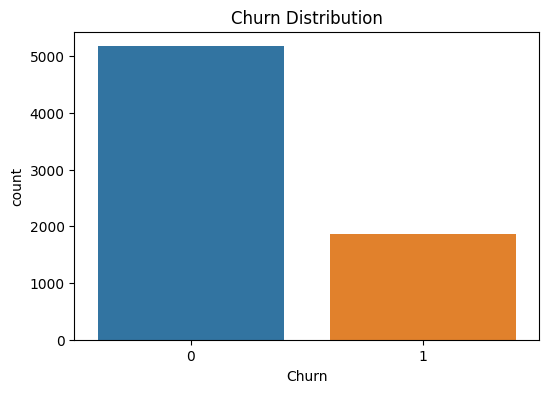

In [17]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

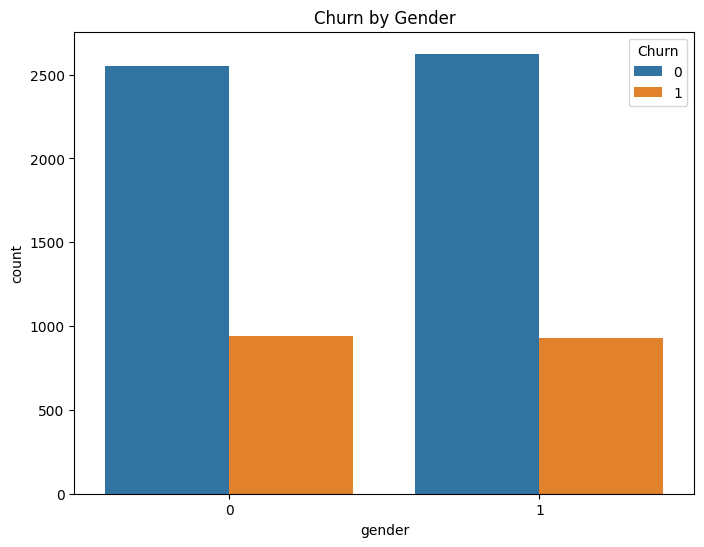

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='Churn', data=df)
plt.title("Churn by Gender")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


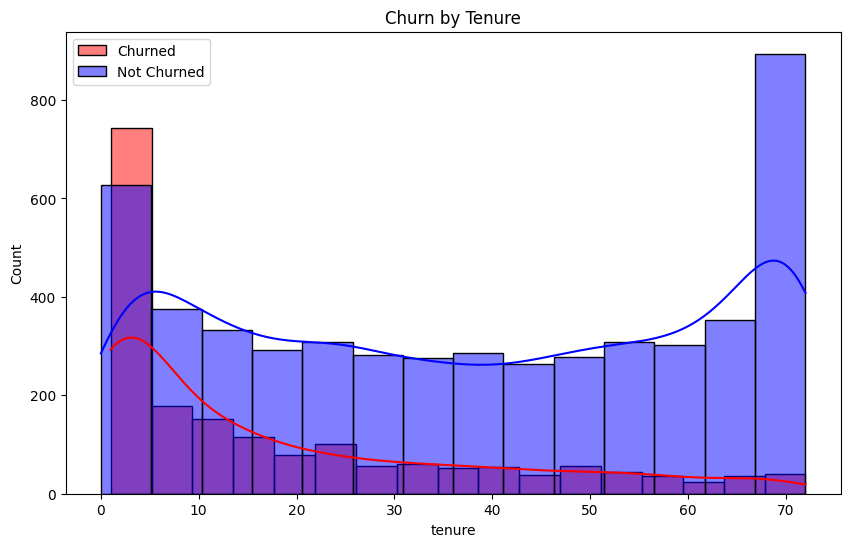

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Churn'] == 1]['tenure'], kde=True, color='red', label='Churned')
sns.histplot(df[df['Churn'] == 0]['tenure'], kde=True, color='blue', label='Not Churned')
plt.legend()
plt.title("Churn by Tenure")
plt.show()

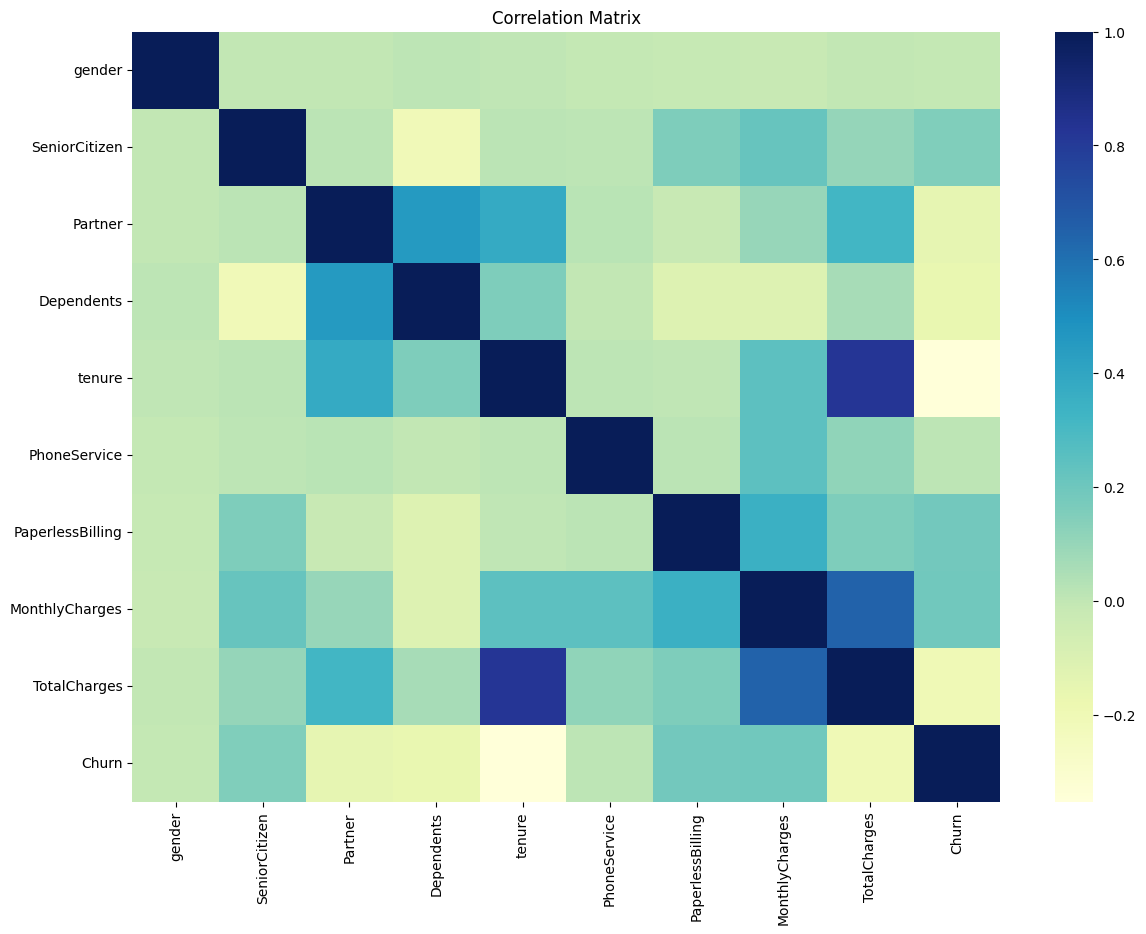

In [21]:
# Check if only numeric data is selected for correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Ensure correlation matrix is not empty
if not corr_matrix.empty:
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr_matrix, annot=False, cmap="YlGnBu")
    plt.title("Correlation Matrix")
    plt.show()
else:
    print("Correlation matrix is empty. Verify data preparation steps.")


In [22]:
df['loyalty_score'] = df['tenure'] * (1 - df['Churn'])  # Higher score for longer tenured non-churned customers
df['service_score'] = df['PhoneService'] + df['MultipleLines'].apply(lambda x: 1 if x == 'Yes' else 0)

In [23]:
contingency = pd.crosstab(df['gender'], df['Churn'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"Chi-square test result for Gender vs Churn: chi2={chi2}, p-value={p}")

Chi-square test result for Gender vs Churn: chi2=0.4840828822091383, p-value=0.48657873605618596


In [24]:
# T-Test on MonthlyCharges for churned vs non-churned customers
churned = df[df['Churn'] == 1]['MonthlyCharges']
non_churned = df[df['Churn'] == 0]['MonthlyCharges']
t_stat, p_val = ttest_ind(churned, non_churned)
print(f"T-test result for MonthlyCharges: t_stat={t_stat}, p-value={p_val}")


T-test result for MonthlyCharges: t_stat=16.536738015936308, p-value=2.7066456068884154e-60


In [25]:
print("Key Insights and Recommendations:")
print("1. Customers with longer tenure are less likely to churn.")
print("2. High monthly charges correlate with churn. Consider offering discounts to high-risk customers.")
print("3. Gender has minimal effect on churn, as indicated by the high p-value.")

Key Insights and Recommendations:
1. Customers with longer tenure are less likely to churn.
2. High monthly charges correlate with churn. Consider offering discounts to high-risk customers.
3. Gender has minimal effect on churn, as indicated by the high p-value.


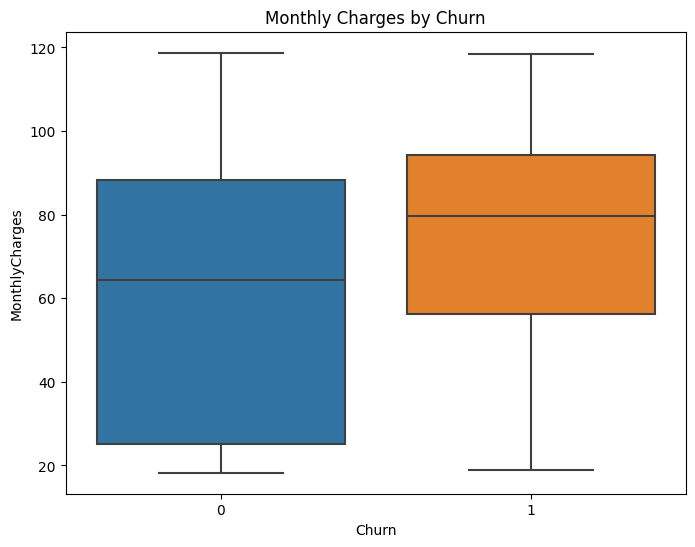

In [26]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['MonthlyCharges', 'TotalCharges', 'tenure']])

# Plotting final insights
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn")
plt.show()